In [1]:
from src import UDP_RX, SlidingBook, MACChecker
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

import socket, struct

#### parameters that needs to be exhanged between the sender and the receiver #####
IP = "0.0.0.0"
PORT = 23422
            #  t1  t2  t3  t4  t5  t6  t7  t8  t9
X = np.array([[ 1,  0,  0,  0,  0,  0,  1,  0,  0], # m1
              [ 1,  0,  0,  0,  0,  0,  0,  1,  0], # m2
              [ 1,  0,  0,  0,  0,  0,  0,  0,  1], # m3
              [ 0,  1,  0,  0,  0,  0,  1,  0,  0], # m4
              [ 0,  1,  0,  0,  0,  0,  0,  1,  0], # m5
              [ 0,  1,  0,  0,  0,  0,  0,  0,  1], # m6
              [ 0,  0,  1,  0,  0,  0,  1,  0,  0], # m7
              [ 0,  0,  1,  0,  0,  0,  0,  1,  0], # m8
              [ 0,  0,  1,  0,  0,  0,  0,  0,  1], # m9
              [ 0,  0,  0,  1,  0,  0,  1,  0,  0], # m10
              [ 0,  0,  0,  1,  0,  0,  0,  1,  0], # m11
              [ 0,  0,  0,  1,  0,  0,  0,  0,  1], # m12
              [ 0,  0,  0,  0,  1,  0,  1,  0,  0], # m13
              [ 0,  0,  0,  0,  1,  0,  0,  1,  0], # m14
              [ 0,  0,  0,  0,  1,  0,  0,  0,  1], # m15
              [ 0,  0,  0,  0,  0,  1,  1,  0,  0], # m16
              [ 0,  0,  0,  0,  0,  1,  0,  1,  0], # m17
              [ 0,  0,  0,  0,  0,  1,  0,  0,  1]]) # m18
            #  t1  t2  t3  t4  t5  t6  t7  t8  t9
Y = np.array([[ 0,  0,  0,  0,  0,  0,  1,  0,  0], # m1
              [ 0,  0,  0,  0,  0,  0,  0,  1,  0], # m2
              [ 1,  0,  0,  0,  0,  0,  0,  0,  0], # m3
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m4
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m5
              [ 0,  1,  0,  0,  0,  0,  0,  0,  0], # m6
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m7
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m8
              [ 0,  0,  1,  0,  0,  0,  0,  0,  0], # m9
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m10
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m11
              [ 0,  0,  0,  1,  0,  0,  0,  0,  0], # m12
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m13
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m14
              [ 0,  0,  0,  0,  1,  0,  0,  0,  0], # m15
              [ 0,  0,  0,  0,  0,  0,  0,  0,  0], # m16
              [ 0,  0,  0,  0,  0,  1,  0,  0,  0], # m17
              [ 0,  0,  0,  0,  0,  0,  0,  0,  1]]) # m18

# X = np.eye(18)
# Y = np.eye(18)

IP = "0.0.0.0"
PORT = 23422
Packet_Payload_Size_Bytes = 128
key = b"key"
digestmod = 'sha384'

offset = 0

# start a server to get the clinets time
with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.bind((IP, PORT))
    s.listen()
    conn, addr = s.accept()
    with conn:
        print('Connected by', addr)
        data1 = conn.recv(1024)
        data2 = conn.recv(1024)
        conn.sendall(b"ok")
        conn.close()

offset = struct.unpack('d',data2)[0] - time.time()


# buffer =  SlidingBook(num_pages=10, page_size=X.shape[0])
# page_processor = MACChecker(X = X, Y = Y, secret_key=key, digestmod=digestmod)
# udp_rx = UDP_RX(IP= IP, PORT= PORT, buffer=buffer, page_processor= page_processor, Payload_Size_Byte=Packet_Payload_Size_Bytes)
# msg, verification_count, latency = udp_rx.receive()

# plt.plot(verification_count)
# plt.show()
# plt.plot(latency)
# plt.show()



total_avg_verification = []
# total_not_verified_cnt = []
# tag_per_message_cnt = []
total_latency = []
cnt = 0

start = time.time()

while True:
    cnt += 1
    buffer =  SlidingBook(num_pages=1000, page_size=X.shape[0])
    page_processor = MACChecker(X = X, Y = Y, secret_key=key, digestmod=digestmod)
    udp_rx = UDP_RX(IP= IP, PORT= PORT, buffer=buffer, page_processor= page_processor, Payload_Size_Byte=Packet_Payload_Size_Bytes)

    msg, verification_count, latency = udp_rx.receive()
    total_avg_verification.append(np.average(verification_count))
    total_latency.append(np.average(latency))
    if msg is not None and len(msg) > 0:  # Ensure rec is not None and has valid data
        nparr = np.frombuffer(msg, np.uint8)
        
        if nparr is not None and len(nparr) > 0:  # Check if nparr is valid
            try:
                frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
                
                if frame is not None:  # Ensure that the frame is successfully decoded
                    cv2.imshow('Received Video', frame)
                    
                    if cv2.waitKey(1) & 0xFF == ord('q'):
                        break
                else:
                    print("Failed to decode frame.")
                    pass
            except Exception as e:
                print(f"Error decoding frame: {e}")
                pass
        else:
            print("Empty or invalid buffer received.")
            pass
    else:
        print("Received an empty or invalid page.")
        pass
    if cnt % 100 == 0:
        print(f"avg_verification: {np.average(total_avg_verification)}, latency: {np.average(total_latency)}")
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    if time.time() - start > 15:
        break
cv2.destroyAllWindows()

Connected by ('10.42.0.1', 33866)


2024-09-01 22:56:27.862 Python[9602:156028] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.
Corrupt JPEG data: premature end of data segment


Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Received an empty or invalid page.


/Users/mohammadkashani/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/mohammadkashani/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Corrupt JPEG data: premature end of data segment


Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.


Corrupt JPEG data: bad Huffman code


Failed to decode frame.
Received an empty or invalid page.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.


Corrupt JPEG data: premature end of data segment


Received an empty or invalid page.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Received an empty or invalid page.
Failed to decode frame.
Received an empty or invalid page.
Failed to decode frame.


Corrupt JPEG data: premature end of data segment


Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Received an empty or invalid page.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Received an empty or invalid page.
Failed to decode frame.
Failed to decode frame.
Received an empty or invalid page.
avg_verification: nan, latency: nan
Failed to decode frame.
Failed to decode frame.


Corrupt JPEG data: premature end of data segment


Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.


Corrupt JPEG data: premature end of data segment


Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.


Corrupt JPEG data: premature end of data segment


Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Received an empty or invalid page.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.


Corrupt JPEG data: premature end of data segment


Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.


Corrupt JPEG data: premature end of data segment


Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Received an empty or invalid page.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.


Corrupt JPEG data: premature end of data segment


Received an empty or invalid page.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Received an empty or invalid page.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
avg_verification: nan, latency: nan
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.
Failed to decode frame.


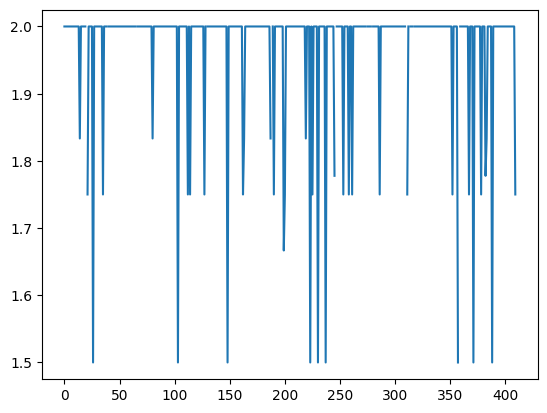

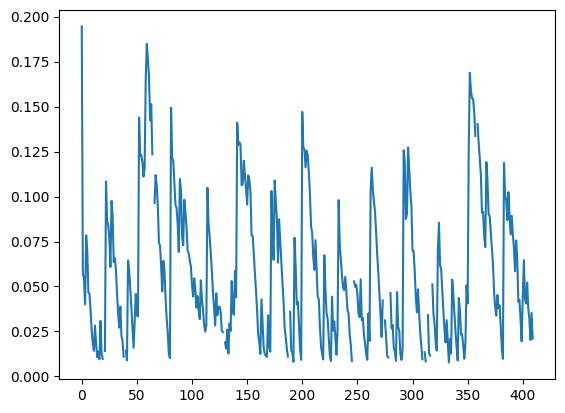

In [ ]:
plt.plot(total_avg_verification)
plt.show()
plt.plot(np.array(total_latency)+offset)
plt.show()